# Регрессия - пора творить!

Если вы дошли до этой практики и выполнили все предыдущие - вау! Аплодисменты вам!

<p align="center"><img src="https://raw.githubusercontent.com/AleksDevEdu/ml_edu/master/assets/leo.png" width=500/></p>



Тем не менее, не время расслабляться! На этот раз, мы не будем рассказывать вам новый материал - лишь дадим пару напутствий и пожелаем успехов и сил!

В этот раз вам предлагается разработать модель предсказания цены домов по набору данных Boston Houses Pricing. Мы его уже немного пощупали в прошлой практике, но в этой вам предстоит сделать всё самостоятельно и на полных данных!

Что надо будет сделать:
- Загрузить данные
- Посмотреть и размер, и примеры данных
- Проверить количество пропусков в данных
    - Убедиться, что пропусков в данных нет и можно строить **baseline**
- Делим данные на train и test 
    - Делаем это один раз! Все дальнейшие модификации и улучшения должны делаться на основе единственного разделения!
    - И не забудьте зафиксировать сид! Переменную `RANDOM_SEED` мы даём ниже
- Создаем baseline модель, снимаем метрики на тестовой выборке
- Производим анализ данных, готовим план по очистке и предобработке данных
- Создаем функцию очистки
- Производим очистку train и test выборок -> обучаем модель с очищенными данными
    - Снимаем метрики и так мы оцениваем влияние очистки данных на обучение
- Создаем класс предобработки данных
- Производим предобработку очищенных данных -> обучаем модель
    - Снимаем метрики и так мы оцениваем влияние предобработки данных на обучение

А дальше можете пофантазировать, почитать интернет и посмотреть, как улучшить метрики! 

**Ваша цель - достигнуть наилучших показателей!**

Вот вам пара идей по интересной организации предобработке:
- По признаку `CRIM` создать признак `is_CRIM`, который будет равен 1, если `CRIM` не равен 0 и 0, если `CRIM` равен нулю
- Сделать обучение модели [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html), посмотреть, какие признаки имеют веса близкие к 0 и убрать их из обучения как незначимые
- Оставить только признаки с высокой корреляцией с целевой переменной
- Посмотреть, какие переменные коррелирцют между собой и оставить только единственные из пар коррелирующих
- Посмотреть, в каких примерах данных модель ошибается сильнее всего (отсортировать записи из теста по величине ошибки) и проанализировать, есть ли какая-то зависимость или шум
- Комбинировать разные подходы в зависимости от того, помогает это предсказаниям или нет

Ещё большим плюсом будет, если вы покажете, как влияет каждый этап предобработки на результаты обучения!

In [1]:
# Зафиксируем состояние случайных чисел
import numpy as np
import random

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

Что мы ждем от вас? 

Готовый ноутбук с таким же названием, в котором будут обязательные пункты с выводами по анализу данных и анализу поведения модели, а также дополнительные пункты по вашим размышлениям и процессу улучшения модели.

Успехов вам, мы в вас верим и уверены, что вы точно справитесь!

<p align="center"><img src="https://raw.githubusercontent.com/AleksDevEdu/ml_edu/master/assets/cat-computer-peek-out-36960208.jpg" width=600/></p>

In [2]:
import pandas as pd


df_src = pd.read_csv('boston.csv')
df_src.shape

(506, 14)

In [3]:
from sklearn.model_selection import train_test_split


data_copy = df_src.copy()
MEDV_column = data_copy.pop('MEDV')


train_X, test_X, train_Y, test_Y = train_test_split(
    data_copy,
    MEDV_column,
    test_size=.3,
    random_state=RANDOM_SEED,
    shuffle=True
)

In [4]:
from sklearn import linear_model


reg_model = linear_model.LinearRegression()
reg_model.fit(train_X, train_Y)
y_pred = reg_model.predict(test_X)

In [5]:
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score
)


mae = mean_absolute_error(test_Y, y_pred)
mse = mean_squared_error(test_Y, y_pred)
r2 = r2_score(test_Y, y_pred)
mae, mse, r2


(3.1627098714573947, 21.51744423117709, 0.7112260057484948)

<AxesSubplot: >

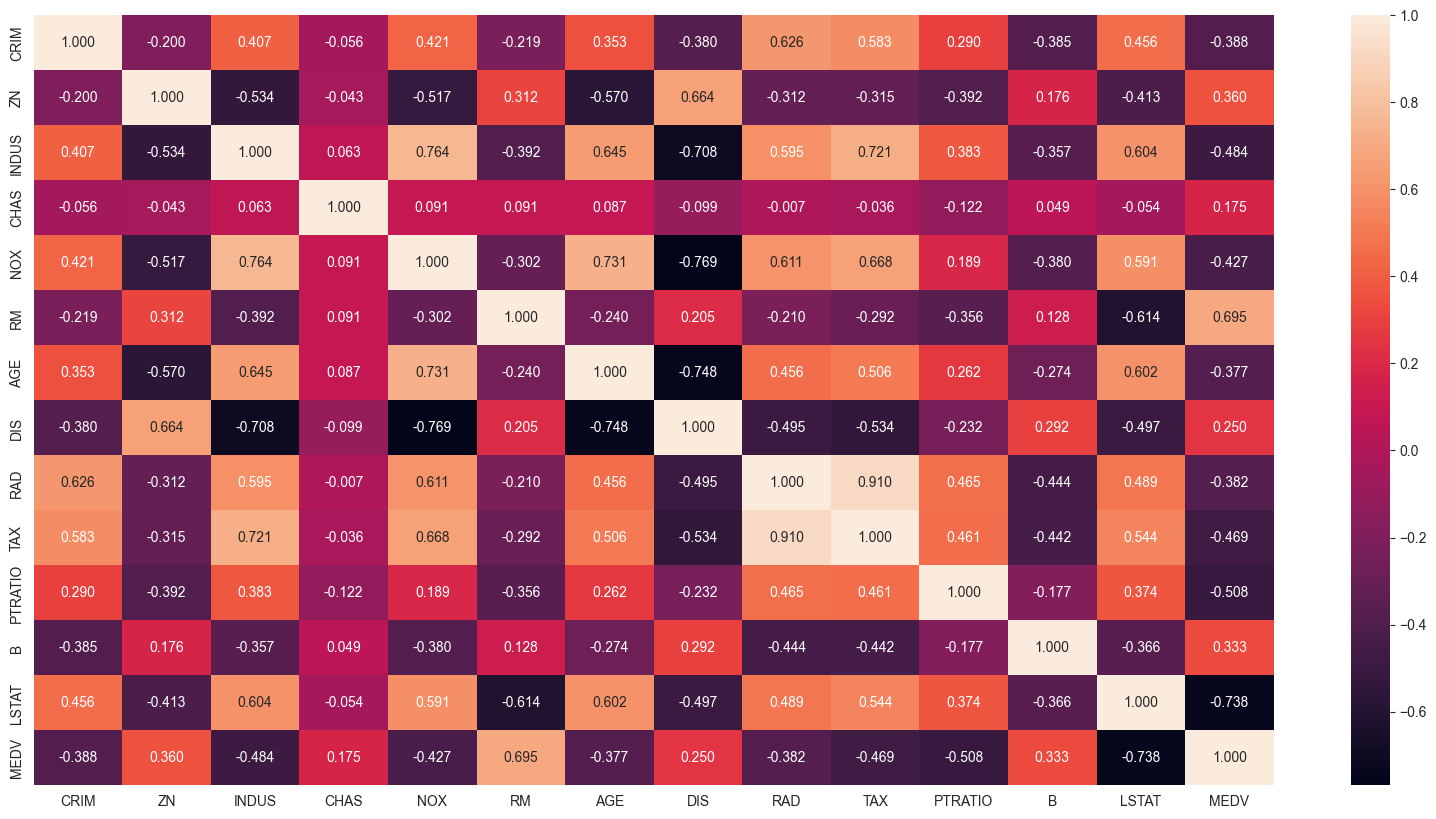

In [6]:
import seaborn as sns
from matplotlib import pyplot as plt


corr_matrix = df_src.corr()
plt.figure(figsize=(20, 10))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt='.3f'
)

In [7]:
data_new = df_src

mask_1 = data_new['MEDV'] == 50
mask_2 = data_new['RM'] < 4
mask_3 = (data_new['RM'] > 8) & (data_new['MEDV'] < 30)
mask_4 = (data_new['INDUS'] > 14) & (data_new['INDUS'] < 15.5)
mask_5 = data_new['NOX'] > 0.8
mask_6 = data_new['RAD'] > 20

mask = mask_1 | mask_2 | mask_3 | mask_4 | mask_5 | mask_6


In [8]:
test_X.loc[:, 'MEDV'] = test_Y
train_X.loc[:, 'MEDV'] = train_Y

train_X = (train_X.loc[~mask]).copy()
train_Y = train_X.pop('MEDV')

test_X = (test_X.loc[~mask]).copy()
test_Y = test_X.pop('MEDV')

In [9]:
reg_model = linear_model.LinearRegression()
reg_model.fit(train_X, train_Y)
y_pred = reg_model.predict(test_X)

In [11]:
def metrics(test_y, y_pred):
    results = {
        'mae_score': mean_absolute_error(test_y, y_pred),
        'r2_score': r2_score(test_y, y_pred),
        'mse_score': mean_squared_error(test_y, y_pred)
    }
    return results


metrics(test_Y, y_pred)

{'mae_score': 2.1725856897285527,
 'r2_score': 0.830399789549862,
 'mse_score': 8.231209457775268}

In [12]:
mod_Lasso = linear_model.Lasso(
    alpha=0.0000001,
    random_state=RANDOM_SEED
)
mod_Lasso.fit(train_X, train_Y)
weight = mod_Lasso.coef_
print(
    mod_Lasso.intercept_,
    weight,
    f'Max: {weight.max()}',
    f'Min: {weight.min()}',
    sep="\n"
)


-17.580881579265697
[ 0.75683966  0.01702977  0.02268401  0.10533017 -0.82486257  8.92551828
 -0.07298417 -0.85562653  0.25347209 -0.00948293 -0.51636494  0.01138068
 -0.01055872]
Max: 8.925518277298428
Min: -0.85562653192029


In [13]:
y_pred_1 = mod_Lasso.predict(test_X)
metrics(test_Y, y_pred_1)

{'mae_score': 2.172585701791056,
 'r2_score': 0.8303997499226017,
 'mse_score': 8.23121138100566}

Метрики не улучшились

In [14]:
from sklearn.preprocessing import MinMaxScaler


class DataPreprocessing:

    def __init__(self):
        self.scaler = MinMaxScaler()

    def fit(self, data):
        DIS_log = np.log(data['DIS'])
        data.loc[:, 'DIS'] = DIS_log
        data.loc[:, 'LSTAT_poly_2'] = data['LSTAT'] ** 2
        data.reset_index(inplace=True)
        data.loc[:, 'is_CRIM'] = data['CRIM'].apply(lambda x: 0 if (x < 0.01) else 1)

        self.scaler = self.scaler.fit(data)

    def transform(self, data):
        df_1_train = data.loc[~mask]
        data_change = self.scaler.transform(df_1_train)
        data_change = pd.DataFrame(
            {
                'CRIM': data_change[:, 0],
                'ZN': data_change[:, 1],
                'INDUS': data_change[:, 2],
                'CHAS': data_change[:, 3],
                'NOX': data_change[:, 4],
                'RM': data_change[:, 5],
                'AGE': data_change[:, 6],
                'DIS': data_change[:, 7],
                'RAD': data_change[:, 8],
                'TAX': data_change[:, 9],
                'PTRATIO': data_change[:, 10],
                'B': data_change[:, 11],
                'LSTAT': data_change[:, 12],
                'MEDV': data_change[:, 13],
                'LSTAT_poly_2': data_change[:, 14],
                'is_CRIM': data_change[:, 15]
            }
        )
        return data_change

In [15]:
preproc = DataPreprocessing()

data_set = train_X.copy()
preproc.fit(data_set)
change_train = preproc.transform(data_set)

preproc = DataPreprocessing()
data_set = test_X.copy()
preproc.fit(data_set)

change_test = preproc.transform(data_set)

In [17]:
train_X_change = change_train.copy()
train_Y_change = train_X_change.pop('MEDV')

test_X_change = change_test.copy()
test_Y_change = test_X_change.pop('MEDV')

mod_Lasso = linear_model.Lasso(alpha=0.0000001, random_state=RANDOM_SEED)
mod_Lasso.fit(train_X_change, train_Y_change)
y_pred1_change = mod_Lasso.predict(test_X_change)

In [20]:
metrics(test_Y_change, y_pred1_change)

{'mae_score': 0.032790947176739485,
 'r2_score': 0.9594411828647368,
 'mse_score': 0.0021679024796863082}

**ВЫВОД**:
____
В результате предобработки получен коэффициент = 0.96, т.е. способность к высокой – предсказательности.
При изначальном значении 0.83. "Чистка" признаков из обучающей выборки не дало результата.